In [71]:
import boto3
from PIL import Image
import io
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import pickle
import torch
from torch.utils.data import random_split
import random

# Take raw data and generate training and test data

In [62]:
MAX_PIXEL_VALUE = 65535
BUCKET_NAME = "cindy-profiling"
RAW_BASE_PATH = "TargetActivationAdvanced/"
CLEAN_BASE_PATH = "Data/"

In [36]:
def get_raw_image(image_name):
    s3 = boto3.client("s3")
    response = s3.get_object(Bucket = BUCKET_NAME, Key = RAW_BASE_PATH + image_name)
    content = response["Body"].read()
    image_file = io.BytesIO(content)
    image = Image.open(image_file)
    return image

In [56]:
files = []
s3 = boto3.resource("s3")
bucket = s3.Bucket("cindy-profiling")
for obj in bucket.objects.filter(Prefix = RAW_BASE_PATH):
    files.append(obj.key.split("/")[-1])

In [40]:
def gen_mask(d2_file):
    img = get_raw_image(d2_file)

    pixel_grid = np.array(img)
    num_rows = len(pixel_grid)
    linear_pixels = pixel_grid.flatten()
    pixel_stdev = np.std(linear_pixels, ddof =1)
    pixel_mean = linear_pixels.mean()
    pixel_threshold = pixel_mean + pixel_stdev * 1.5

    l_mask = []
    for pixel in linear_pixels:
        l_mask.append(1 if pixel > pixel_threshold else 0)

    np_mask = np.array(l_mask)
    mask = np_mask.reshape(num_rows, -1)

    masked_img = []
    for i, pixel in enumerate(np_mask):
        masked_img.append(MAX_PIXEL_VALUE if pixel == 1 else 0)
    masked_img = np.array(masked_img)
    masked_img = masked_img.reshape(num_rows, -1)
    return masked_img

In [41]:
masked_img = gen_mask("localhost231204150002_H02f07d2.TIFF")

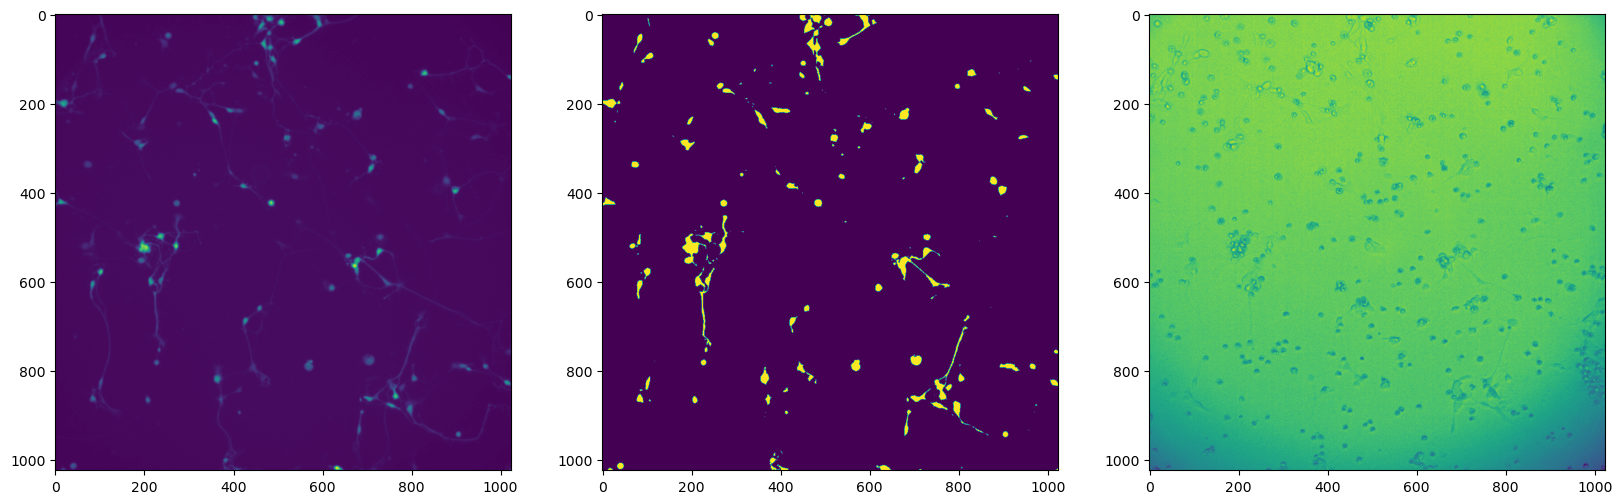

In [42]:
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (20, 10))
axes[0].imshow(get_raw_image('localhost231204150002_H02f07d2.TIFF'))
axes[1].imshow(masked_img)
axes[2].imshow(get_raw_image("localhost231204150002_H02f07d3.TIFF"))

In [58]:
data_pairs = []
misses = []
for file in files:
  if file.split(".")[0][-1] == "2":
    brightfield = file.split(".")[0][:-1] + "3.TIFF"
    if brightfield in files:
      data_pairs.append([file, brightfield])
    else:
      misses.append(brightfield)

In [60]:
for i in tqdm(range(len(data_pairs))):
  mask = gen_mask(data_pairs[i][0])
  data_pairs[i].append(mask)

100%|██████████| 259/259 [04:54<00:00,  1.14s/it]


In [65]:
pickle_byte_obj = pickle.dumps(data_pairs)
s3 = boto3.resource("s3")
bucket = s3.Bucket(BUCKET_NAME)
bucket.put_object(Key = CLEAN_BASE_PATH + "data_pairs.pkl", Body = pickle_byte_obj)

s3.Object(bucket_name='cindy-profiling', key='Data/data_pairs.pkl')

In [ ]:
# s3 = boto3.resource("s3")
# response = s3.get_object(Bucket = BUCKET_NAME, Key = CLEAN_BASE_PATH + "data_pairs.pkl")
# content = response["Body"].read()
# image_file = io.BytesIO(content)
# image = Image.open(image_file)

In [66]:
well_to_samples = {}
for file in files:
    identifier = file.split("_")[-1].split(".")[0]

    if file.split(".")[0][-2:] != "d3":
      continue
    well = identifier.split("f")[0]

    if well in well_to_samples:
        well_to_samples[well].add(identifier.split("f")[1])
    else:
        well_to_samples[well] = set([identifier.split("f")[1]])

for well in well_to_samples:
  well_to_samples[well] = list(well_to_samples[well])

In [70]:
TRAIN_RATIO = 0.8
VALIDATION_RATIO = 0
TEST_RATIO = 1 - (TRAIN_RATIO + VALIDATION_RATIO)
seed = 42
torch.manual_seed(seed)
random.seed(seed)

In [72]:
train_samples = []
test_samples = []
generator = torch.Generator().manual_seed(seed)
for well, samples in well_to_samples.items():
  train_subset, test_subset = random_split(samples, [TRAIN_RATIO, TEST_RATIO], generator = generator)
  train_list = [well + "f" + train_subset[i] for i in range(len(train_subset))]
  test_list = [well + "f" + test_subset[i] for i in range(len(test_subset))]
  train_samples += train_list
  test_samples += test_list

/Users/aryomanpatel/miniconda3/envs/f_mlbase/lib/python3.10/site-packages/torch/utils/data/dataset.py:449: UserWarning: Length of split at index 1 is 0. This might result in an empty dataset.
  warnings.warn(f"Length of split at index {i} is 0. "


In [73]:
print("Number of training samples: ",len(train_samples))
print("Number of test samples: ", len(test_samples))
print("% training samples: ", round(len(train_samples)/(len(train_samples) + len(test_samples)) * 100, 2) )

Number of training samples:  223
Number of test samples:  40
% training samples:  84.79


In [74]:
train_data = []
test_data = []

for data_split in data_pairs:
  identifier = data_split[1].split("_")[-1].split(".")[0]
  if identifier in train_samples:
    train_data.append(data_split.copy())
  else:
    test_data.append(data_split.copy())

In [75]:
print(len(train_data))
print(len(test_data))

220
39


In [79]:
print(train_data[0][0])
train_data[0][0].split("_")[-1].split(".")[0][:-2]

localhost231204150002_A02f00d2.TIFF


'A02f00'

In [87]:
s3 = boto3.resource("s3")
bucket = s3.Bucket(BUCKET_NAME)

for train_pair in train_data:
    file_name = train_pair[0].split("_")[-1].split(".")[0][:-2]
    train_binary = pickle.dumps(train_pair)
    bucket.put_object(Key = CLEAN_BASE_PATH + f"train/{file_name}.pkl", Body = train_binary)
for test_pair in test_data:
    file_name = test_pair[0].split("_")[-1].split(".")[0][:-2]
    test_binary = pickle.dumps(test_pair)
    bucket.put_object(Key = CLEAN_BASE_PATH + f"test/{file_name}.pkl", Body = test_binary)

In [104]:
from torch.utils.data import Dataset
import os

class DataPairsDataset(Dataset):
  def __init__(self, train_test, transform=None):
    self.train_test = train_test
    self.transform = transform

    self.images = []
    s3 = boto3.resource("s3")
    bucket = s3.Bucket("cindy-profiling")
    for obj in bucket.objects.filter(Prefix = f"Data/{self.train_test}/"):
        self.images.append(obj.key.split("/")[-1])

    self.images_container_path = f"{RAW_BASE_PATH}"


  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
    s3 = boto3.client("s3")
    response = s3.get_object(Bucket = BUCKET_NAME, Key = f"Data/{self.train_test}/{self.images[idx]}")
    pickled_data = pickle.loads(response["Body"].read())

    brightfield_path = pickled_data[1]
    brightfield_image = np.array(get_raw_image(brightfield_path))


    mask = pickled_data[2]
    mask[mask == 26113] = 1.0

    if self.transform is not None:
      augmentations = self.transform(image = brightfield_image, mask = mask)
      brightfield_image = augmentations["image"]
      mask = augmentations["mask"]
    return brightfield_image, mask

In [97]:
s3 = boto3.resource("s3")
bucket = s3.Bucket("cindy-profiling")
files = []
for obj in bucket.objects.filter(Prefix = f"Data/test"):
    files.append(obj.key.split("/")[-1])

In [99]:
s3 = boto3.client("s3")
response = s3.get_object(Bucket = BUCKET_NAME, Key = f"Data/test/A02f04.pkl")

In [102]:
obj = pickle.loads(response["Body"].read())

In [103]:
obj

['localhost231204150002_A02f04d2.TIFF',
 'localhost231204150002_A02f04d3.TIFF',
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])]